In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re


sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
varinfo.X_m = dict(bins=np.linspace(500,2000,30))
varinfo.Y1_m = dict(bins=np.linspace(0,1000,30))
varinfo.Y2_m = dict(bins=np.linspace(0,1000,30))
varinfo.H1Y1_m = dict(bins=np.linspace(0,250,30))
varinfo.H2Y1_m = dict(bins=np.linspace(0,250,30))
varinfo.H1Y2_m = dict(bins=np.linspace(0,250,30))
varinfo.H2Y2_m = dict(bins=np.linspace(0,250,30))

In [3]:
signal = ObjIter([Tree(fc.eightb.preselection_ranked_quadh.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
# signal_asym = ObjIter([Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
qcd = ObjIter([Tree(fc.eightb.preselection_ranked_quadh.QCD_B_List)])
# qcd_asym = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])
ttbar = ObjIter([Tree(fc.eightb.preselection_ranked_quadh.TTJets)])
# ttbar = ObjIter([])
bkg = qcd + ttbar
# qcd = ObjIter([])
data = ObjIter([Tree(fc.eightb.preselection_ranked_quadh.JetHT_Run2018A_UL)])

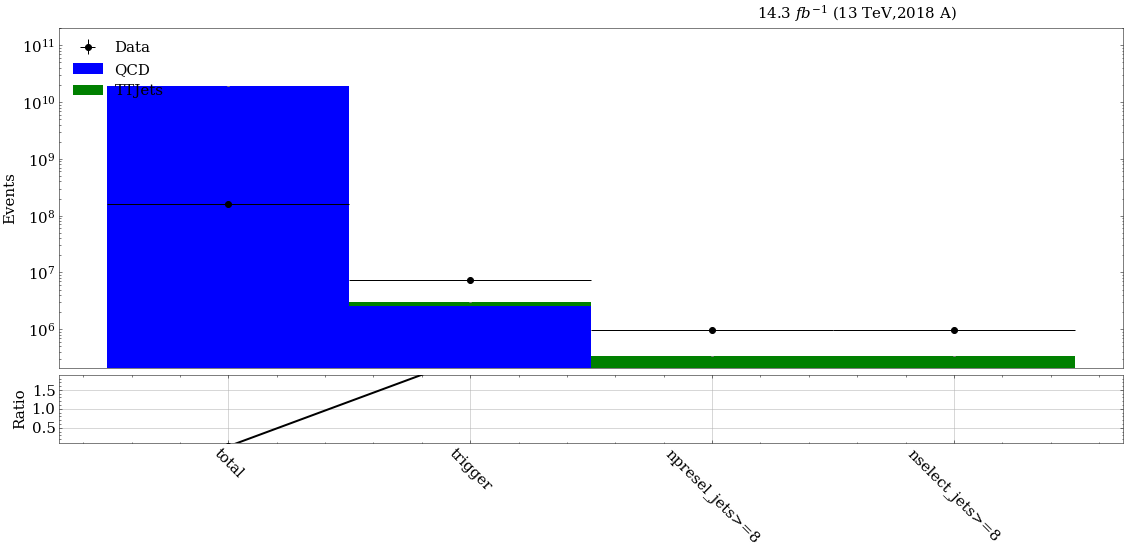

In [6]:
study.cutflow(
  data+bkg, stacked=True, legend=True,
  lumi=20180,

  ratio=True,
)

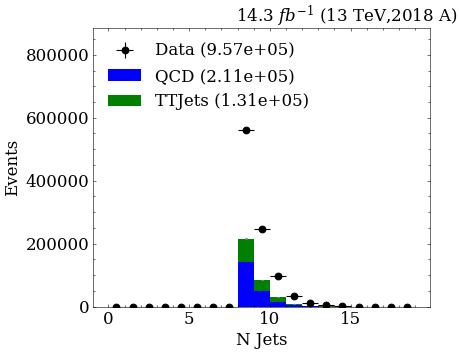

In [7]:
study.quick(
  data+bkg, stacked=True, legend=True,
  varlist=['n_jet'],
  binlist=[np.arange(0,20)],
  saveas='n_jet',
  lumi=20180
)

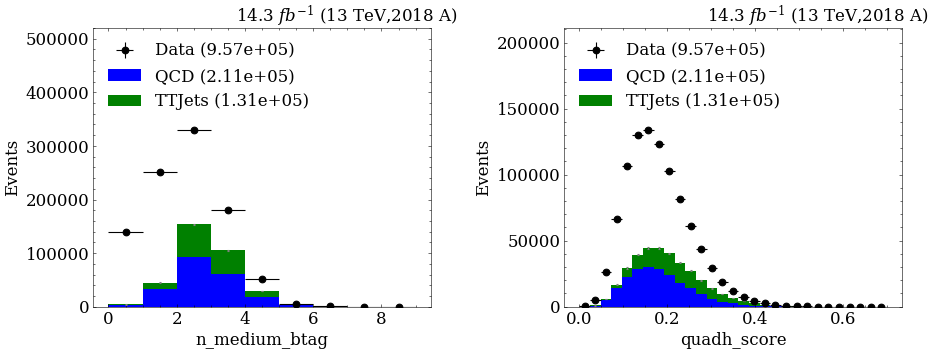

In [8]:
study.quick(
  data+bkg, stacked=True, legend=True,
  varlist=['n_medium_btag','quadh_score'],
  binlist=[None, (0,0.7,30)],
  lumi=20180,
  saveas='selection_variables'
)

In [9]:
blind = EventFilter('blinded', filter=lambda t:~((t.n_medium_btag>=5)&(t.quadh_score>=0.2)))
def get_model(data):
  model = data.copy()
  model.sample = 'model'
  model.is_model = True
  return model
model = data.apply(get_model)

In [10]:
def get_abcd_masks(v1_r, v2_r):
  v1_sr = lambda t : (t.n_medium_btag >= v1_r[1]) & (t.n_medium_btag < v1_r[2])
  v1_cr = lambda t : (t.n_medium_btag >= v1_r[0]) & (t.n_medium_btag < v1_r[1])

  v2_sr = lambda t : (t.quadh_score >= v2_r[1]) & (t.quadh_score < v2_r[2])
  v2_cr = lambda t : (t.quadh_score >= v2_r[0]) & (t.quadh_score < v2_r[1])

  r_a = lambda t : v1_sr(t) & v2_sr(t)
  r_b = lambda t : v1_cr(t) & v2_sr(t)

  r_c = lambda t : v1_sr(t) & v2_cr(t)
  r_d = lambda t : v1_cr(t) & v2_cr(t)
  return r_a, r_b, r_c, r_d

def get_region_scale(r, model=model):
  t = model.apply(lambda t:t.scale).apply(np.sum).npy.sum()
  n = model.apply(lambda t:t.scale[r(t)]).apply(np.sum).npy.sum()
  e = np.sqrt(model.apply(lambda t:(t.scale[r(t)])**2).apply(np.sum).npy.sum())
  return n/t,e/t


def get_abcd_scale(r_a, r_b, r_c, r_d):
  n_d, e_d = get_region_scale(r_d)
  n_c, e_c = get_region_scale(r_c)
  n_b, e_b = get_region_scale(r_b)
  n_a, e_a = get_region_scale(r_a)

  k_factor = n_c/n_d
  e_factor = k_factor*np.sqrt( (e_c/n_c)**2 + (e_d/n_d)**2 )
  k_target = n_a/n_b
  e_target = k_target*np.sqrt( (e_a/n_a)**2 + (e_b/n_b)**2 )

  n_model = k_factor*n_b
  e_model = n_model*np.sqrt( (e_factor/k_factor)**2 )

  return (k_target, e_target), (k_factor, e_factor), (n_model, e_model)

In [11]:
abcd_regions = {
  'nominal':                    [(0,5,9),(0,0.2 ,1)],
  'validation/btag_hi':         [(3,5,9),(0,0.2 ,1)],
  'validation/btag_lo':         [(0,3,5),(0,0.2 ,1)],
  'validation/score_lo':        [(0,5,9),(0,0.15,0.2)],
  'validation/btag_hi_score_lo':[(3,5,9),(0,0.15,0.2)],
  'validation/btag_lo_score_lo':[(0,3,5),(0,0.15,0.2)]
}

In [22]:
v1_r, v2_r = abcd_regions['validation/score_lo']
r_a, r_b, r_c, r_d = get_abcd_masks(v1_r, v2_r)
(k_target, e_target), (k_factor, e_factor), (n_model, e_model) = get_abcd_scale(r_a, r_b, r_c, r_d)

(k_factor, 100*e_factor/k_factor)

(0.008491618247105258, 1.817492989606454)

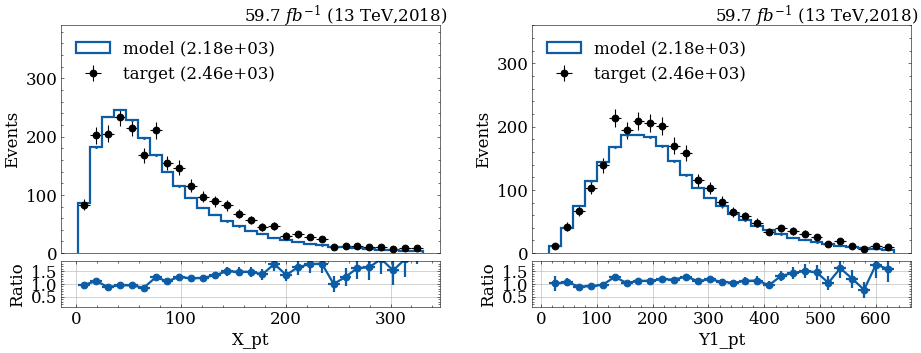

In [23]:
study.quick_region(
  data, model, 
  varlist=['X_pt','Y1_pt'],
  h_color=None, label=['target','model'], legend=True,
  masks=[r_a]*len(data) + [r_b]*len(model),
  scale=[None]*len(data) + [k_factor]*len(model),
  h_label_stat=lambda h:f'{np.sum(h.weights):0.2e}',

  ratio=True,

  saveas='model_X_m'
)

In [52]:
ratio = k_target/k_factor
# error = ratio*np.sqrt( (e_target/k_target)**2 + (e_factor/k_factor)**2 )
error = ratio*np.sqrt( (e_factor/k_factor)**2 )

ratio, error/ratio

(1.1350352663777197, 0.04978759899905877)

In [66]:
x = np.linspace(0, 1.5, 1000)
y = f_stats.kstwobign.sf(x)

In [72]:
from scipy import optimize

def f(x):
  return np.abs(f_stats.kstwobign.sf(x) - 0.05)

optimize.fmin(f, 1)

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 14
         Function evaluations: 28


array([1.35810547])

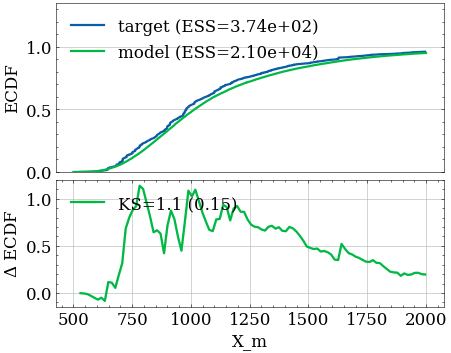

In [64]:
study.quick_region(
  bkg, bkg, 
  varlist=['X_m'],
  h_color=None, label=['target','model'], legend=True,
  masks=[r_a]*len(bkg) + [r_b]*len(bkg),
  scale=[None]*len(bkg) + [k_factor]*len(bkg),
  h_label_stat=lambda h:f'ESS={np.sum(h.weights)**2/np.sum(h.weights**2):0.2e}',

  histo=False,
  empirical=True,
  e_legend=True,
  e_ylim=(0,1.35),

  e_difference=True,
  e_d_size='75%',
  e_d_ylabel='$\Delta$ ECDF',
  e_d_legend_loc='upper left',

  saveas='model_X_m_kstest'
)

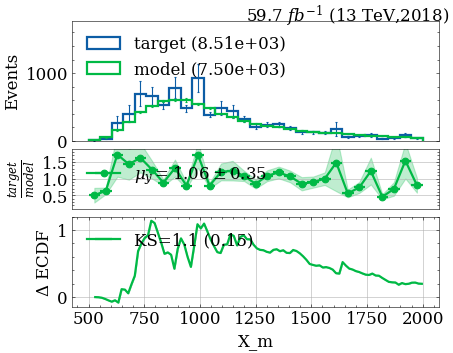

In [16]:
study.quick_region(
  bkg, bkg, 
  varlist=['X_m'],
  h_color=None, label=['target','model'], legend=True,
  masks=[r_a]*len(bkg) + [r_b]*len(bkg),
  scale=[None]*len(bkg) + [k_factor]*len(bkg),
  h_label_stat=lambda h:f'{np.sum(h.weights):0.2e}',
  legend_loc='upper left',

  ratio=True,
  r_size='50%',
  r_fill_error=True,
  r_ylabel=r'$\frac{target}{model}$',
  r_label_stat='y_mean_std',
  r_legend=True,
  r_legend_loc='upper left',

  empirical=True,
  # e_ylim=(-0.15,1.15),
  e_show=False,

  e_difference=True,
  e_d_size='75%',
  e_d_ylabel='$\Delta$ ECDF',
  e_d_legend_loc='upper left',

  saveas='model_X_m_full'
)